# Build Datasets: ML & CV Orchestrator

Run from the **project root**. It uses your `scripts/` modules to generate:
- ML features and labels parquet datasets
- Optional CV image renders for visual QA

Edit parameters in the next cell and execute top-to-bottom.


In [1]:
# Рабочий каталог = корень проекта
import os, sys, pathlib
ROOT = pathlib.Path(r"C:\Users\Admin\Desktop\Code\Trade-bot")  # подправь путь при необходимости
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Авто-перезагрузка модулей при правках
%load_ext autoreload
%autoreload 2

import platform, pandas as pd
print("CWD:", pathlib.Path().resolve())
print("Python:", platform.python_version())


CWD: C:\Users\Admin\Desktop\Code\Trade-bot
Python: 3.11.0


In [15]:
TICKER     = "GAZP" # ["SBER", "GAZP", "LKOH", "ROSN", "GMKN"]
TF         = "5m"                  # "1m" / "5m" / "1h" / "1d"
START      = "2024-10-17"
END        = "2025-10-17"
FIGI       = "BBG004730RP0"          # BBG004730N88 — SBER. BBG004730RP0 — GAZP. BBG004731032 — LKOH. BBG004731354 — ROSN. BBG004731489 — GMKN.
YF_SYMBOL  = "GAZP.ME"               # запасной символ для yfinance

RAW_GLOB   = f"data/raw/*/{TICKER}/{TF}/year=*/month=*/part.parquet"
FEAT_PATH  = f"data/features/ml/{TICKER}/{TF}/features.parquet"
FEAT_LBL   = f"data/features/ml/{TICKER}/{TF}/features_labeled.parquet"


In [16]:
from scripts import fetch_data as F
import pandas as pd

# В модуле могло не быть fetch_intraday — добавим тонкую обёртку тут
def fetch_intraday(ticker: str, tf: str, start, end, figi: str|None=None, yf_symbol: str|None=None):
    if hasattr(F, "fetch_intraday"):
        return F.fetch_intraday(ticker, tf, start, end, figi, yf_symbol)
    # Иначе используем функции из модуля (Tinkoff -> MOEX -> yfinance)
    from datetime import datetime
    def _dt(x): 
        return x if isinstance(x, datetime) else datetime.fromisoformat(str(x))
    START, END = _dt(start), _dt(end)
    try:
        if figi:
            dft = F.fetch_tinkoff_chunked(figi, tf, START, END)
            if not dft.empty:
                return dft.sort_values("time").drop_duplicates("time"), "tinkoff"
    except Exception: 
        pass
    try:
        dfm = F.fetch_moex_history(ticker, tf, str(START.date()), str(END.date()))
        if not dfm.empty:
            return dfm.sort_values("time").drop_duplicates("time"), "moex"
    except Exception:
        pass
    sym = yf_symbol or f"{ticker}.ME"
    dfy = F.fetch_yf(sym, tf, str(START.date()))
    if not dfy.empty:
        return dfy.sort_values("time").drop_duplicates("time"), "yfinance"
    return pd.DataFrame(), None

df_raw, src = fetch_intraday(TICKER, TF, START, END, figi=FIGI, yf_symbol=YF_SYMBOL)
print("source:", src, "rows:", len(df_raw), df_raw["time"].min() if len(df_raw) else None, "→", df_raw["time"].max() if len(df_raw) else None)
df_raw.head()


source: tinkoff rows: 77589 2024-10-17 04:00:00+00:00 → 2025-10-16 20:45:00+00:00


,time,open,high,low,close,volume
0,2024-10-17 04:00:00+00:00,136.99,137.48,136.99,137.14,204
1,2024-10-17 04:05:00+00:00,137.44,137.44,137.10,137.22,984
2,2024-10-17 04:10:00+00:00,137.11,137.22,137.10,137.10,191
3,2024-10-17 04:15:00+00:00,137.10,137.10,137.10,137.10,167
4,2024-10-17 04:20:00+00:00,137.10,137.29,137.10,137.28,39


In [17]:
if not df_raw.empty:
    F.save_partitioned(df_raw, source=src or "tinkoff", ticker=TICKER, tf=TF)


In [18]:
from scripts.make_intraday_features import build_features
import os
os.makedirs(os.path.dirname(FEAT_PATH), exist_ok=True)

fe = build_features(RAW_GLOB)
fe.to_parquet(FEAT_PATH, index=False)
len(fe), FEAT_PATH


(77589, 'data/features/ml/GAZP/5m/features.parquet')

In [19]:
from scripts.make_labels import next_k_return, triple_barrier
import numpy as np, pandas as pd

# 1) Загружаем признаки
df = pd.read_parquet(FEAT_PATH).sort_values("time").copy()

# 2) TF -> минуты и горизонт H в барах
def tf_to_minutes(tf: str) -> int:
    tf = tf.strip().lower()
    if tf.endswith("m"): return int(tf[:-1])
    if tf.endswith("h"): return int(tf[:-1]) * 60
    if tf.endswith("d"): return int(tf[:-1]) * 60 * 24
    raise ValueError(f"Unsupported TF: {tf}")

TF_MIN   = tf_to_minutes(TF)   # напр., "5m" -> 5
H_MIN    = 180                 # 180 минут (3 часа) — ваш целевой горизонт
H        = max(1, H_MIN // TF_MIN)

# --- ключевая настройка порога в процентах ---
THRESH_PCT = 0.02              # 2% = 0.02 (от цены на момент t)

# 3) Контрольная метрика ретурна
df = next_k_return(df, k=H)    # создаст ret_fwd_{H}

# (опционально) если ATR вам не нужен — весь блок ATR можно убрать.
# Ниже оставлен только фильтр «в один торговый день» и хвост

# 4) Фильтр «t и t+H в один торговый день» + убрать хвост без будущего
if len(df) > H:
    ts = pd.to_datetime(df["time"], utc=True).dt.tz_convert("Europe/Moscow")
    same_day = ts.dt.normalize().eq(ts.shift(-H).dt.normalize())
    before = len(df)
    df = df[same_day].copy()
    if len(df) > H:
        df = df.iloc[:-H].copy()
    print(f"[same_day] kept {len(df)}/{before} rows after tail trim")

# 5) Разметка triple-barrier фиксированным 2%-порогом
df = triple_barrier(df, k=H, up=THRESH_PCT, dn=THRESH_PCT)  # создаст y_tb_{H} ∈ {1,0,-1}

# 6) Границы для рендера
ymin, ymax = float(df["low"].min()), float(df["high"].max())

# 7) Сохраняем датасет
df.to_parquet(FEAT_LBL, index=False)
print(f"Saved labeled dataset: {FEAT_LBL}, rows={len(df)}, H={H} bars ({H_MIN} min @ TF={TF})")
flat_share = (df.get(f"y_tb_{H}", pd.Series(dtype=float)) == 0).mean()
print(f"Share of 'flat' labels: {flat_share:.2%}")
print(f"Used fixed thresholds: up=dn={THRESH_PCT:.4f}  ({THRESH_PCT*100:.2f}%)")


[same_day] kept 64449/77589 rows after tail trim
Saved labeled dataset: data/features/ml/GAZP/5m/features_labeled.parquet, rows=64449, H=36 bars (180 min @ TF=5m)
Share of 'flat' labels: 92.82%
Used fixed thresholds: up=dn=0.0200  (2.00%)


In [20]:
from joblib import Parallel, delayed
from scripts.render_cv_images import render_with_manifest

def render_batch(start_idx):
    return render_with_manifest(
        in_parquet = FEAT_LBL,
        ticker     = TICKER,
        tf         = TF,
        size       = 64,
        step       = 16,                 # 50–75% overlap
        horizon    = H,
        show_axes  = False,
        show_volume= True,
        vol_mode   = "zscore",          # было "raw" → сделай устойчивым
        fixed_ylim = "window",           # было (ymin, ymax); сделай по окну
        ylim_pad   = 0.02,               # добавь небольшой паддинг
        ohlc_mode  = "close+hl_wick",    # 1 канал close + тени HL
        extra_ch   = "atr_rel",          # опционально 3-й канал: ATR/close
        manifest_csv = f"data/cv/images/{TICKER}/{TF}/batch_{start_idx}.csv",
        seed = 42
    )


Parallel(n_jobs=4)(delayed(render_batch)(i) for i in range(4))


[[{'path': 'data\\cv\\images\\GAZP\\5m\\w64_s16\\0.0\\img_0000000.png',
   'ticker': 'GAZP',
   'tf': '5m',
   't_start': '2024-10-17 04:00:00+00:00',
   't_end': '2024-10-17 09:30:00+00:00',
   'bars': 64,
   'ymin': 135.62,
   'ymax': 138.3,
   'vol_mode': 'zscore',
   'vmin': -0.8588364363760556,
   'vmax': 4.24689151767965,
   'label': '0.0',
   'ret_fwd': nan,
   'horizon': 36,
   'extra_ch': 'atr_rel'},
  {'path': 'data\\cv\\images\\GAZP\\5m\\w64_s16\\0.0\\img_0000001.png',
   'ticker': 'GAZP',
   'tf': '5m',
   't_start': '2024-10-17 05:20:00+00:00',
   't_end': '2024-10-17 10:50:00+00:00',
   'bars': 64,
   'ymin': 134.8,
   'ymax': 138.3,
   'vol_mode': 'zscore',
   'vmin': -0.9895910751444609,
   'vmax': 4.00549831221404,
   'label': '0.0',
   'ret_fwd': nan,
   'horizon': 36,
   'extra_ch': 'atr_rel'},
  {'path': 'data\\cv\\images\\GAZP\\5m\\w64_s16\\0.0\\img_0000002.png',
   'ticker': 'GAZP',
   'tf': '5m',
   't_start': '2024-10-17 06:55:00+00:00',
   't_end': '2024-10-17 

In [21]:
# from scripts.render_cv_images import render_with_manifest
# MANIFEST = f"data/cv/images/{TICKER}/{TF}/win64_step16/manifest_with_vol.csv"
# 
# rows = render_with_manifest(
#     in_parquet = FEAT_LBL,
#     ticker     = TICKER,
#     tf         = TF,
#     size       = 64,
#     step       = 16,
#     horizon    = H,
#     show_axes  = True,          # True для дебага с осями
#     show_volume= True,           # рисуем колонны объёма
#     vol_mode   = "raw",          # 'raw' | 'zscore' | 'rel'
#     fixed_ylim = (ymin, ymax),       # автоскейл по окну для цен
#     manifest_csv = MANIFEST
# )
# len(rows), MANIFEST


In [22]:
import pandas as pd
df = pd.read_parquet(FEAT_LBL)
same_price_windows = df["high"].eq(df["low"]).mean()
print(f"{same_price_windows*100:.2f}% окон без диапазона")

3.79% окон без диапазона


In [23]:
from scripts.qc_report import qc_summary
qc = qc_summary(RAW_GLOB)
qc


,rows,zero_price,bad_hl,zero_vol,max_gap
0,77589,0,0,0,1 days 07:15:00


In [24]:
import glob
files = glob.glob(f"data/features/ml/{TICKER}/{TF}/*.parquet")
mart = (pd.concat((pd.read_parquet(p) for p in files), ignore_index=True)
          .drop_duplicates("time").sort_values("time"))
os.makedirs("warehouse", exist_ok=True)
MART_FILE = f"warehouse/{TICKER.lower()}_{TF}.parquet"
mart.to_parquet(MART_FILE, index=False)
len(mart), MART_FILE


(77589, 'warehouse/gazp_5m.parquet')

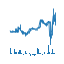

In [26]:
# показать одну сгенерированную картинку
from IPython.display import Image, display
import glob
imgs = glob.glob(f"data/cv/images/{TICKER}/{TF}/w64_s16/*/img_*.png")
display(Image(filename=imgs[0])) if imgs else print("Нет изображений.")


Playing with stochastic

In [ ]:
# Monte-Carlo valuation: FV/PV, mispricing metrics
import numpy as np, pandas as pd
from dataclasses import dataclass

# --- вход: путь к файлу с ценами (достаточно колонок time, close) ---
PATH = f"warehouse/{TICKER.lower()}_{TF}.parquet"  # можно заменить на daily файл с колонками time, close
# TICKER = "SBER"

# --- параметры моделирования ---
HORIZON_DAYS = 20             # горизонт прогноза в торговых днях
N_SIMS       = 20000          # число симуляций
MODEL        = "gbm"          # "gbm" или "bootstrap" (эмпирическое бутстрапирование дневных ретёрнов)
DT           = 1/252          # шаг (в годах) для дневной сетки
R_ANNUAL     = 0.12           # годовая ставка дисконтирования (напр., рубл. безрисковая/требуемая доходность)
USE_LOG      = True           # PV/FV считаем из лог-нормальной цены
SEED         = 42

# --- подготовка дневных ретёрнов из произвольной частоты ---
df = pd.read_parquet(PATH).sort_values("time").copy()
df["time"] = pd.to_datetime(df["time"])
# если это минутки — агрегируем в дневные "close" по последнему бару
daily = (df.set_index("time")[["close"]]
           .resample("1D").last()
           .dropna().rename(columns={"close":"close"}))

# фильтр по торговым дням (исключим дни без движения, если были)
daily = daily.replace([np.inf, -np.inf], np.nan).dropna()
px = daily["close"].astype(float)
r  = np.log(px).diff().dropna() if USE_LOG else px.pct_change().dropna()

# --- калибровка параметров GBM ---
mu_hat  = r.mean() * 252      # годовой дрейф по историческим данным
sig_hat = r.std(ddof=1) * np.sqrt(252)  # годовая волатильность

@dataclass
class MCResult:
    fv_stats: pd.DataFrame
    pv_stats: pd.DataFrame
    details: dict

np.random.seed(SEED)
S0 = float(px.iloc[-1])

def mc_simulate(S0, horizon_days, n_sims, model="gbm"):
    steps = horizon_days
    if model == "gbm":
        # дневная дискретизация GBM
        mu_d  = mu_hat / 252.0
        sig_d = sig_hat / np.sqrt(252.0)
        # S_T = S0 * exp(sum((mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z))
        z = np.random.normal(size=(steps, n_sims))
        increments = (mu_d - 0.5*sig_d**2) + sig_d * z  # dt=1 день
        log_ST = np.log(S0) + increments.sum(axis=0)
        ST = np.exp(log_ST)
    elif model == "bootstrap":
        # эмпирическое бутстрапирование дневных ретов
        boot_r = np.random.choice(r.values, size=(steps, n_sims), replace=True)
        if USE_LOG:
            ST = S0 * np.exp(boot_r.sum(axis=0))
        else:
            ST = S0 * np.prod(1 + boot_r, axis=0)
    else:
        raise ValueError("Unknown model")
    return ST

# --- считaем распределения FV и PV ---
ST = mc_simulate(S0, HORIZON_DAYS, N_SIMS, MODEL)
# FV = ST (будущая стоимость на горизонте)
FV = ST
# PV = ожидаемая будущая стоимость, дисконтированная в "сегодня"
disc = np.exp(-R_ANNUAL * (HORIZON_DAYS/252.0))
PV  = FV * disc

def summarize(vec):
    return pd.Series({
        "mean": np.mean(vec),
        "median": np.median(vec),
        "p05": np.percentile(vec, 5),
        "p25": np.percentile(vec, 25),
        "p75": np.percentile(vec, 75),
        "p95": np.percentile(vec, 95),
        "std": np.std(vec, ddof=1)
    })

fv_stats = summarize(FV)
pv_stats = summarize(PV)

# --- метрики "переоценен/недооценен" ---
cur = S0
# вероятность, что дисконтированная стоимость > текущей цены
p_pv_gt_spot = float((PV > cur).mean())
# ожидаемая доходность к горизонту (реальная, не дисконт.)
exp_ret = float((FV/cur - 1.0).mean())
# миспрайсинг как отношение справедливой PV к споту
pv_fair = pv_stats["mean"]
mispricing_ratio = float(pv_fair / cur)   # >1 недооценен, <1 переоценен
# z-score текущей цены относительно PV-распределения
pv_std = pv_stats["std"]
pv_z = float((cur - pv_fair) / pv_std) if pv_std > 0 else np.nan
# вероятность убытка на горизонте
p_loss = float((FV < cur).mean())
# ожидаемый shortfall при 5% (ES)
q05 = np.percentile(FV, 5)
es05 = float(FV[FV <= q05].mean()) if (FV <= q05).any() else np.nan

report = pd.DataFrame({
    "ticker": [TICKER],
    "model": [MODEL],
    "S0": [cur],
    "H_days": [HORIZON_DAYS],
    "r_annual": [R_ANNUAL],
    "mu_ann_hist": [mu_hat],
    "sigma_ann_hist": [sig_hat],
    "PV_mean": [pv_fair],
    "PV/Spot": [mispricing_ratio],
    "PV_z": [pv_z],
    "P(PV>Spot)": [p_pv_gt_spot],
    "E[Ret]": [exp_ret],
    "P(Loss)": [p_loss],
    "ES_5pct": [es05],
    "FV_p05": [np.percentile(FV,5)],
    "FV_p50": [np.percentile(FV,50)],
    "FV_p95": [np.percentile(FV,95)]
})

print("=== FV stats ==="); display(fv_stats.to_frame("value"))
print("=== PV stats ==="); display(pv_stats.to_frame("value"))
print("=== Valuation report ==="); display(report)


In [36]:
# HAR-RV из минуток → дневная RV → OLS с константой → прогноз σ на следующий день

import numpy as np, pandas as pd, statsmodels.api as sm

# 1) загрузка минуток (должны быть time, close)
m = pd.read_parquet(FEAT_PATH).sort_values("time").copy()
m["time"] = pd.to_datetime(m["time"], utc=True)

# 2) минутные лог-ретёрны и дневная realized variance
m["ret"] = np.log(m["close"]).diff()
m["date"] = m["time"].dt.tz_convert(None).dt.date
rv_daily = (m.dropna(subset=["ret"])
              .groupby("date")["ret"]
              .apply(lambda x: np.sum(x.values**2))
              .rename("rv")
              .to_frame())

# 3) признаки HAR: d-1, weekly(5), monthly(22) — все лагируем на 1 день
d = rv_daily.copy()
d["rv_d1"] = d["rv"].shift(1)
d["rv_w"]  = d["rv"].rolling(5).mean().shift(1)
d["rv_m"]  = d["rv"].rolling(22).mean().shift(1)

# 4) обучающая выборка без NaN
D = d.dropna().copy()
assert len(D) >= 40, "Мало данных для HAR-RV"

# 5) дизайн-матрица c константой
X = sm.add_constant(D[["rv_d1","rv_w","rv_m"]])
y = D["rv"]

model = sm.OLS(y, X).fit()

# 6) предиктор на «завтра»: берём ПОСЛЕДНЮЮ строку признаков и подаём те же столбцы X.columns
x_last = d[["rv_d1","rv_w","rv_m"]].iloc[[-1]].copy()
if x_last.isna().any(axis=1).iloc[0]:
    # если не хватает истории для недельного/месячного окна — используем последнюю валидную строку
    x_last = D[["rv_d1","rv_w","rv_m"]].iloc[[-1]].copy()

x_last_const = pd.concat([pd.Series({"const":1.0}), x_last.squeeze()]).to_frame().T
x_last_const = x_last_const[X.columns]  # порядок и набор столбцов как у обучения

rv_pred = float(model.predict(x_last_const).iloc[0])
rv_pred = max(rv_pred, 0.0)             # неотрицательность
sigma_pred = float(np.sqrt(rv_pred))    # дневная σ

print(f"HAR-RV: rv_pred={rv_pred:.6f}, sigma_pred={sigma_pred:.6f}")


HAR-RV: rv_pred=0.000214, sigma_pred=0.014637
